### Bagging (Bootstrap Aggregating)
Bagging is an ensemble learning technique that is closely related to the _MajorityVoteClassifier_.
- However, instead of using the same traiing set to fit the individual classifiers in the ensemble, we __draw bootstrap samples (random samples with replacement)__ from the initial training set, which is why bagging is also known as __Bootstrap Aggregating__.

![07_06.png](07_06.png)

#### Bagging in a nutshell

We have seven different training instances that are sampled randomly with replacement in each round of bagging. Each bootstrap sample is then used to fit a classifier $C_j$, which is most typically an __unpruned decision tree__



![07_07.png](07_07.png)

We can see that each classifier receives a random subset of samples from the training set. Each subset contains a certain portion of duplicates and some of the orignal samples don't appear in a resampled dataset at all due to sampling with replacement. Once the individual classifiers are fit to the bootstrap samples, the predictions are combined using majority voting.

__Reference__ _Bagging Predictors, L.Breiman, Machine Learning,_ __24(2):123-140, __ _1996_

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

# drop 1 class

In [3]:
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=y)

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                             random_state=1,
                             max_depth=None)


In [8]:
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0,
                       bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

In [9]:
# Calculate the accuracy score of the prediciton on the trianing and test dataset to compare the performance
# of the bagging classifier

from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' %(tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


Based on the accuracy values that we printed here, the unpruned decision tree predicts all the class labels of the training samples correctly; however the substantially lower test accuracy indicates hgh variance(overfitting) of the model:

In [10]:
bag = bag.fit(X_train, y_train)

y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print('Bagging train/test accuracies %.3f/%.3f' %(bag_train, bag_test))

Bagging train/test accuracies 1.000/0.917


Although the training accuracies of the decision tree and bagging classifier are similar on the trainig set(both 100 percent) , we can see that the bagging classifier has slightly better generalization performance, as estimated on the test set.

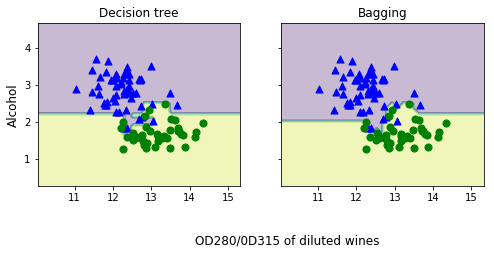

In [18]:
x_min = X_train[:,0].min() - 1
x_max = X_train[:,0].max() + 1
y_min = X_train[:,1].min() - 1
y_max = X_train[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))

for idx, clf, tt in zip([0,1],[tree,bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0], X_train[y_train==0,1], c='blue',marker='^', s=50)
    axarr[idx].scatter(X_train[y_train==1,0], X_train[y_train==1,1], c='green',marker='o', s=50)
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol',fontsize=12)
# plt.text(-3.5, -4.5, s='Sepal width [standarized]' , ha='center', va='center', fontsize=12)
plt.text(10.2, -1.2, s='OD280/0D315 of diluted wines' , ha='center', va='center', fontsize=12)
plt.show()

- <font style="color:red">We shall __note__ that the bagging algorithm can be an effective approach to redcuce the variance of a model.
- However, __bagging is ineffective in reducing model bias, that is, model that are too simple to capture the trend in the data well. __ This is why we want to perform bagging on an ensemble of classifiers with low bias,for example, unpruned decision tree.>/font>

## Boosting


- In boosting the ensemble consists of very simple base classifiers, also often reffered to as __weak learners__,which often only have a slight performance advantage over random guessing - a typical example of a weak learner is a __decision tree stump__.
- The __key__ concept behind boosting is to focus on training samples that are hard to classify that is, to let the weak learners subsequently learn from misclassfied training samples to improve the performance of the ensemble.

__Boosting can lead to a decrease in bias as well as variance as compared to bagging models__. In practive, however, __boosting algorithms such as AdaBoost__ are also known for their high variance, that is the tendency to __overfit the training data.__

In contrast to the original boosting procedure  , adaBoost uses the complete training set to train the weak learners where the training samples are reweighted in each iteration to build a strong classifier that learns from the mistakes fo the previous weak learners in the ensemble.

![Image for AdaBoost operation demonstartions](07_09.png)

We start with subfigure 1, which represents a training set for binary classifcation where all trainig samples are assigned equal weights. Based on this training set, we train a decison stump (shown as a dased line) that tries to classiy the samples of the two classes (traingles and cricles) , as well as possibly by minimizing the cost function (or the impurity score in the special case of decison tree ensembles)

For the next round (subfigure 2) , we assign a larger weight to the two previously misclassified samples(circles). Furthure more, we lower the weight of the correctly classified samples. The next decision stump will now be more focused on the training samples that have the largest weights - the training samples that are supposedly hard to classify. The weak learner shown in subfigure 2 misclassifies three different  samples from the circles class, where are then assigned a larger weight  as show in subfigure 3. 

Assuming that our AdaBoost ensemble only consists of three round of boosting we would then combine the three weak learners trained on differnt reweighted training subsets by a weighted majority vote, as shown in subfigure 4.


-For a better understanding _please refer below video_

[AdaBoost video Reference](https://www.youtube.com/watch?v=LsK-xG1cLYA)

In [ ]:
from IPython.display import HTML

In [23]:
# Youtube
HTML('<iframe width="853" height="480" src="https://www.youtube.com/embed/LsK-xG1cLYA" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
    )
# CREDITS STATQUEST YOUTUBE CHANNEL

In [24]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                             random_state=1,
                             max_depth=1)#max_depth is 1 , it is decision stump.

ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)

In [25]:
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' %(tree_train, tree_test))

Decision tree train/test accuracies 0.916/0.875


In [26]:
ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print('AdaBoost train/test accuracies %.3f/%.3f' %(ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.917


As we can see, the AdaBoost model predicts all class labels of the training set correctly and also shows a slightly improved test set perfromance compared to the decision tree stump. However, we also see that we introduced additional variance by our attempt to reduce the model bias -- a higher gap between training and test performance.

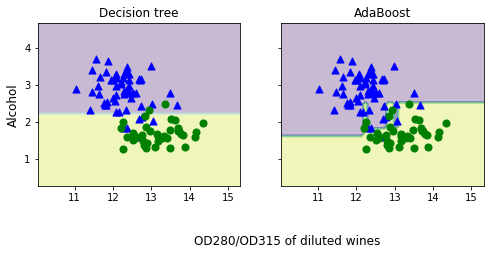

In [28]:
x_min = X_train[:,0].min() - 1
x_max = X_train[:,0].max() + 1
y_min = X_train[:,1].min() - 1
y_max = X_train[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))

for idx, clf, tt in zip([0,1],[tree,ada], ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0], X_train[y_train==0,1], c='blue',marker='^', s=50)
    axarr[idx].scatter(X_train[y_train==1,0], X_train[y_train==1,1], c='green',marker='o', s=50)
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol',fontsize=12)
# plt.text(-3.5, -4.5, s='Sepal width [standarized]' , ha='center', va='center', fontsize=12)
plt.text(10.2, -1.2, s='OD280/OD315 of diluted wines' , ha='center', va='center', fontsize=12)
plt.show()

By looking at the decision regions, we can see that the decision boundary of the AdaBoost model is substantially more complex than the decision boundary of the decision stump. In addition, we note that the AdaBoost model separates the feature space very similarly to the bagging classifier that we trained in the previous section.

- As concluding remarks about ensemble techniques, it is worth noting that __ensemble learing increases the computational complexity compared to individual classifiers. In practice, we need to think carefully about whether we want to pay the price of increased computational costs for an often relatively modest  improvement in predictive perfromance.__